In [348]:
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch import nn
import torch

%config InlineBackend.figure_format = 'retina'

num_samples = 10000


def sin_function(amp, period, phase_shift):
    x = np.arange(num_samples)
    y = amp * np.sin(2 * np.pi * x / period + phase_shift)
    return y


base_freq = 120
seq_len = 240

cut_off_harmonic = 5

/var/folders/1y/_q3nkgrn1f72ccrdw1wl1smh0000gn/T/ipykernel_9505/3063551048.py:62: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies  # Compute periods


Text(0, 0.5, 'Magnitude')

<Figure size 2000x1000 with 0 Axes>

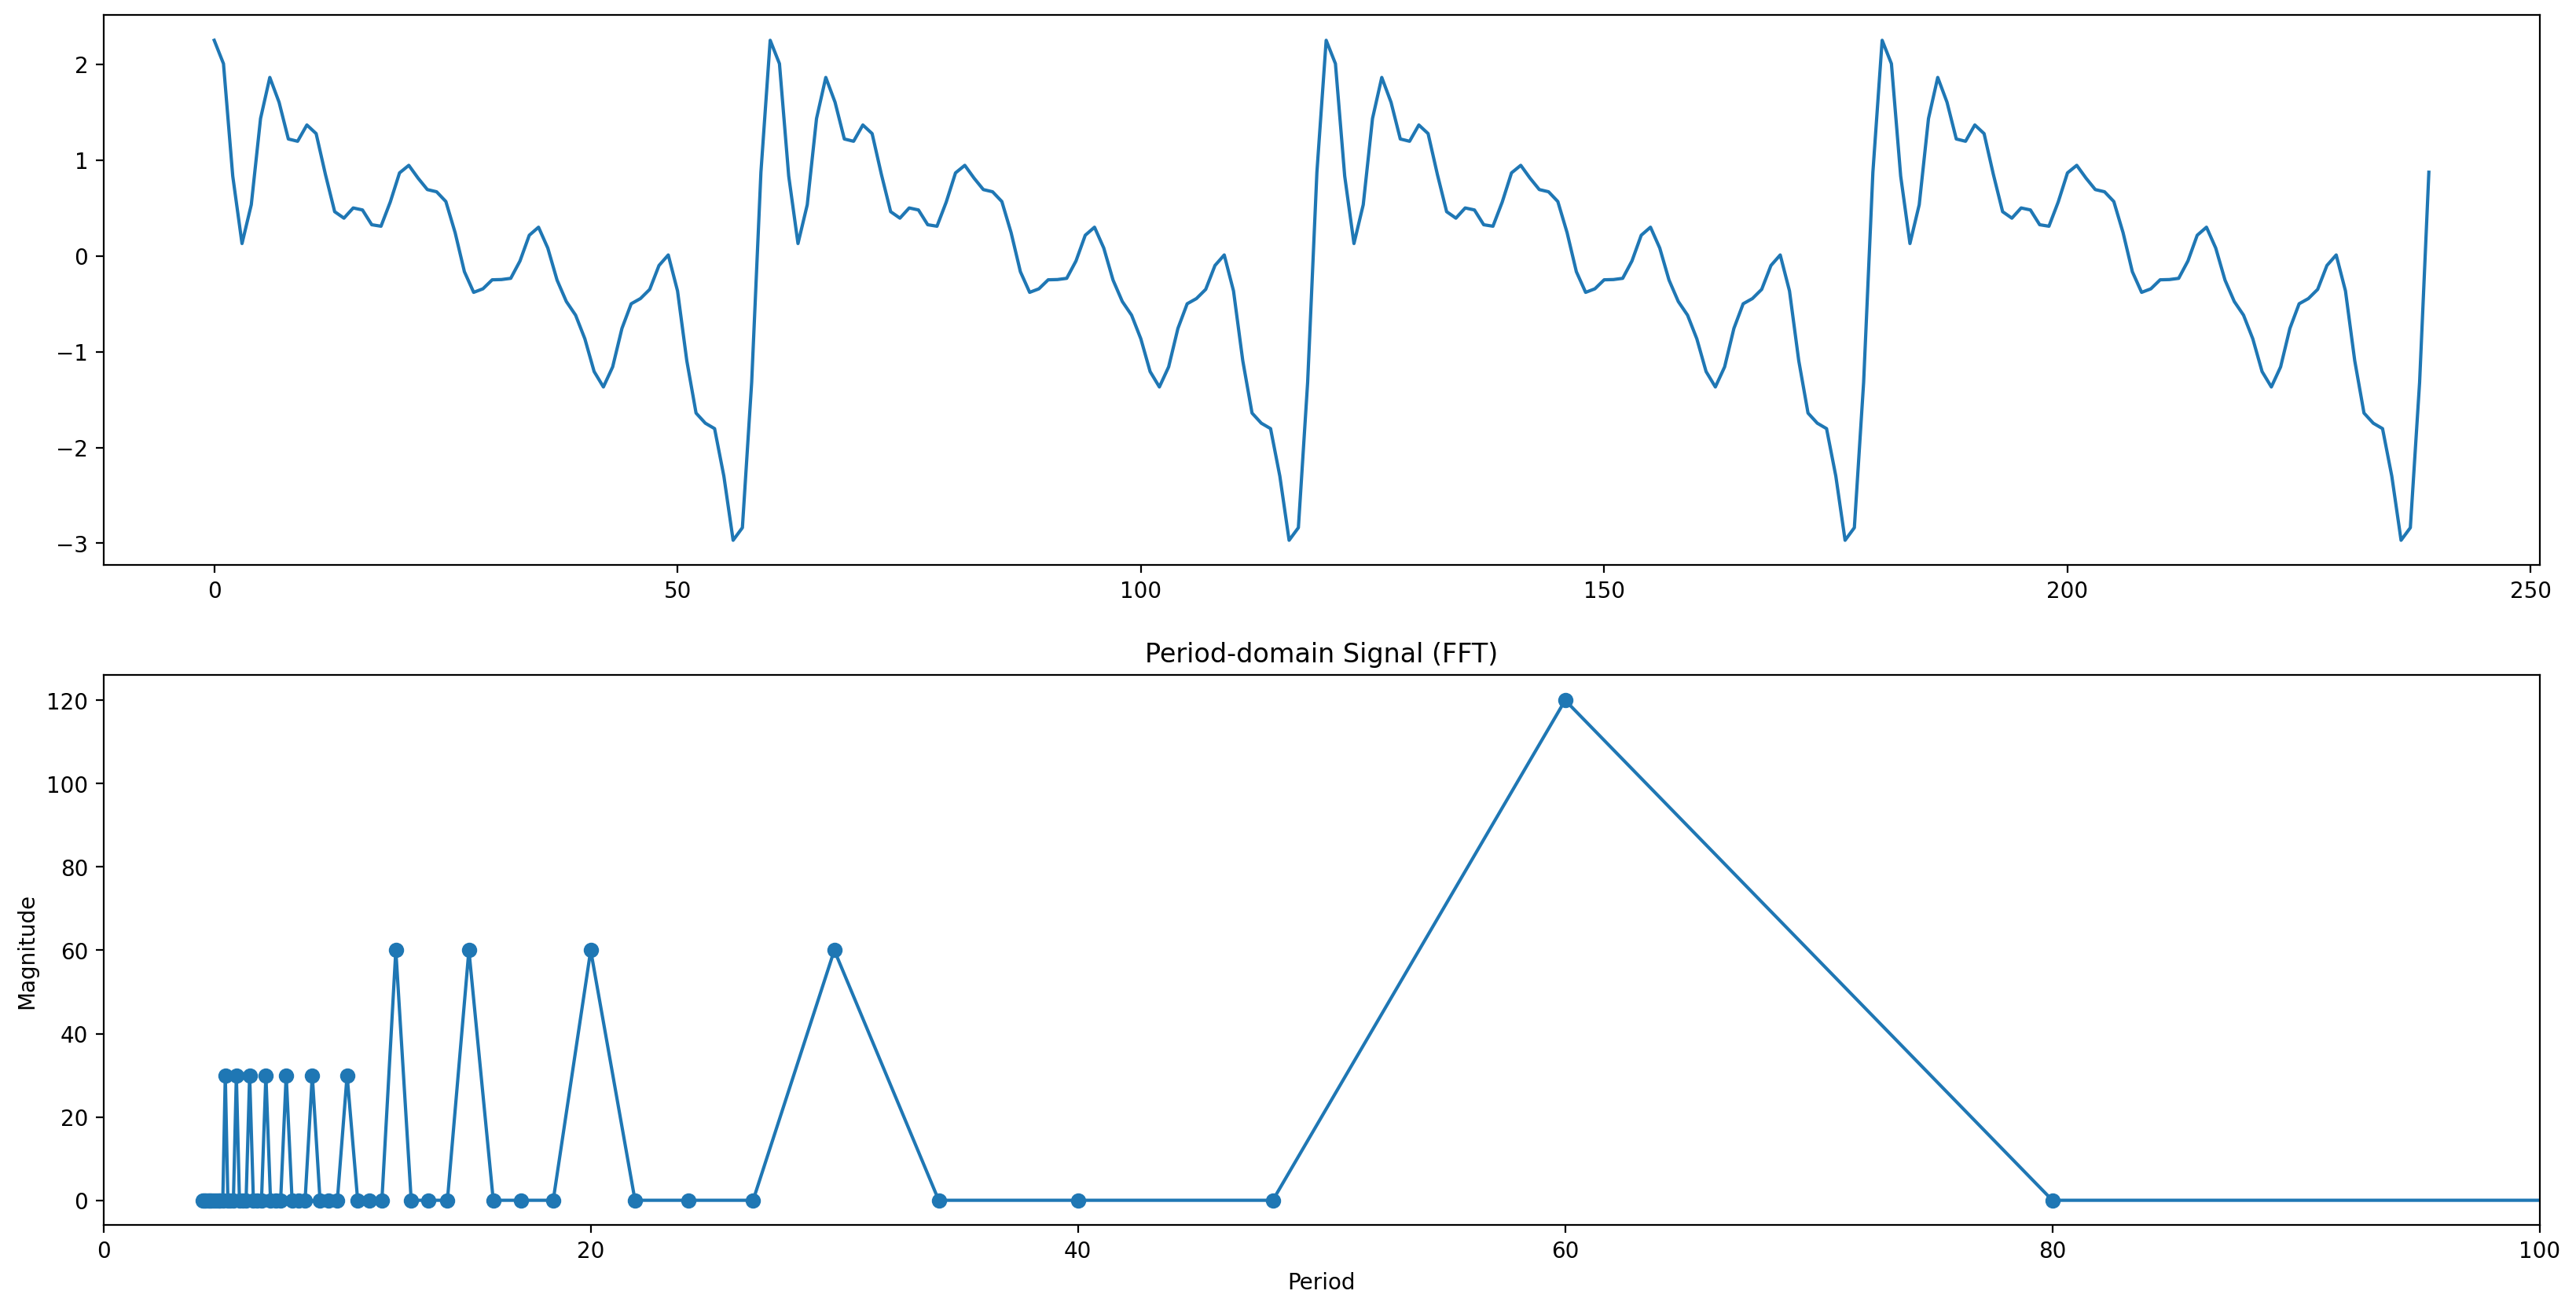

In [349]:
y = np.zeros(num_samples)
base_freq = 60

# # add linear looking trend
# y += sin_function(10, 240, 0)

# 1st harmonic
y = y + sin_function(1, base_freq, 0)

# 2nd harmonic
y += sin_function(0.5, base_freq / 2, 0)

# 3rd harmonic
y += sin_function(0.5, base_freq / 3, 0)

# 4th harmonic
y += sin_function(0.5, base_freq / 4, 0)

# 5th harmonic
y += sin_function(0.5, base_freq / 5, np.pi / 2)

# 6th harmonic
y += sin_function(0.25, base_freq / 6, np.pi / 2)

# 7th harmonic
y += sin_function(0.25, base_freq / 7, np.pi / 2)

# 8th harmonic
y += sin_function(0.25, base_freq / 8, np.pi / 2)

# 9th harmonic
y += sin_function(0.25, base_freq / 9, np.pi / 2)

# 10th harmonic
y += sin_function(0.25, base_freq / 10, np.pi / 2)

# 11th harmonic
y += sin_function(0.25, base_freq / 11, np.pi / 2)

# 12th harmonic
y += sin_function(0.25, base_freq / 12, np.pi / 2)


plt.figure(figsize=(20, 10))
# plt.plot(y[:120])

# plt.plot(np.abs(np.fft.rfft(y[:seq_len]))[:60])

fft_values = np.abs(np.fft.rfft(y[:240]))
frequencies = np.fft.rfftfreq(240, d=1)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(y[:240])
# ax[1].plot(np.abs(np.fft.rfft(y[:240]))[:60], "o-")

# ax[1].plot(frequencies[:60], fft_values[:60], "o-")
# ax[1].set_title("Frequency-domain Signal (FFT)")
# ax[1].set_xlabel("Frequency (Hz)")
# ax[1].set_ylabel("Magnitude")

frequencies = np.fft.rfftfreq(240, d=1)  # Assuming sample spacing of 1
periods = 1 / frequencies  # Compute periods

# Mask the zero frequency component to avoid division by zero
periods[0] = np.inf

ax[1].plot(periods[:60], fft_values[:60], "o-")
ax[1].set_xlim(0, 100)
ax[1].set_title("Period-domain Signal (FFT)")
ax[1].set_xlabel("Period")
ax[1].set_ylabel("Magnitude")
# ax[1].invert_xaxis()

In [350]:
from src.models.FITS import FITS

from argparse import Namespace

args = Namespace(
    dominance_freq=int((240 / base_freq) * cut_off_harmonic),
    seq_len=240,
    pred_len=120,
    channels=1,
    individual=False,
    debug=True,
)

model = FITS(args)

print(model)

FITS(
  (frequency_upsampler): Linear(in_features=20, out_features=30, bias=True)
)


In [351]:
model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [352]:
np.random.permutation(2000).shape

(2000,)

In [353]:
for epoch in range(1000):  # train 1000 epochs
    order = np.random.permutation(int(num_samples * 0.8))  # shuffle the training sample
    train_loss = []
    for batch in range(25):  # split each epoch into 25 batches
        batch_start = order[batch * 80 : (batch + 1) * 80]  # each batch has 80 samples
        batch = []
        for i in batch_start:
            batch.append(y[i : i + 240 + 120])
        batch_xy = np.array(batch).reshape(
            80, 360, 1
        )  # 80 batch_size, 360 time steps, 1 feature

        batch_xy = torch.from_numpy(batch_xy).float()

        batch_x = batch_xy[:, :240, :]
        batch_y = batch_xy[:, 240:, :]

        model_optim.zero_grad()

        output = model(batch_x)

        # output=output[:,-120:,:]

        loss = criterion(
            output, batch_xy
        )  # supervise on xy (only supervise on y also achieve the same result)

        train_loss.append(loss.item())

        loss.backward()

        model_optim.step()

    print(f"\repoch: {epoch} \t loss: {np.mean(train_loss):4f}", end="", flush=True)

epoch: 999 	 loss: 0.343750

In [354]:
output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

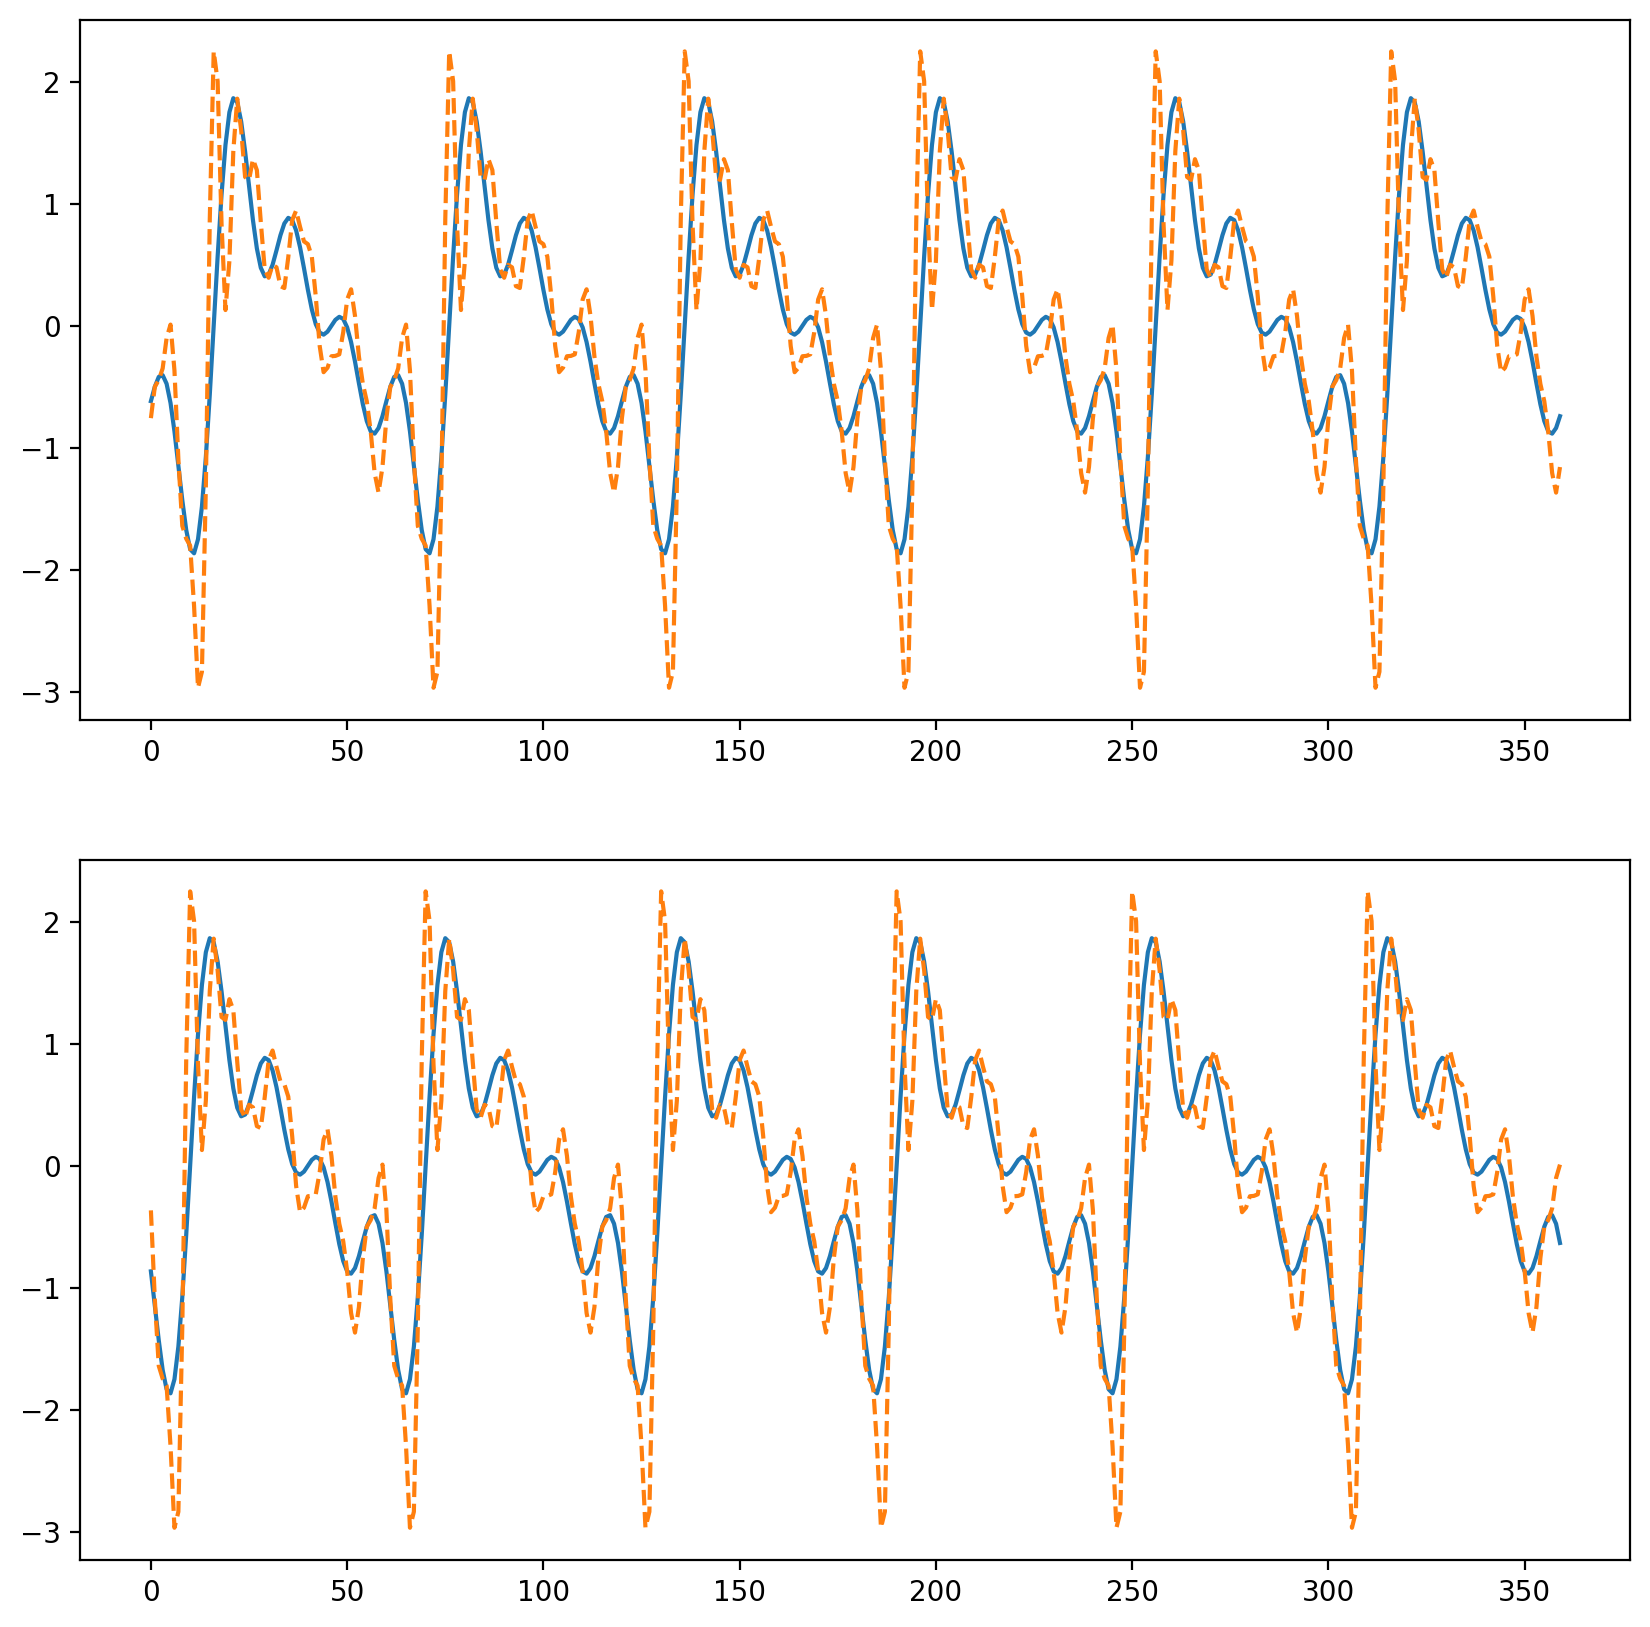

In [355]:
# Visualize the training result
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth
plt.subplot(2, 1, 2)
plt.plot(output[1, :, 0])
plt.plot(batch_xy[1, :, 0], "--")

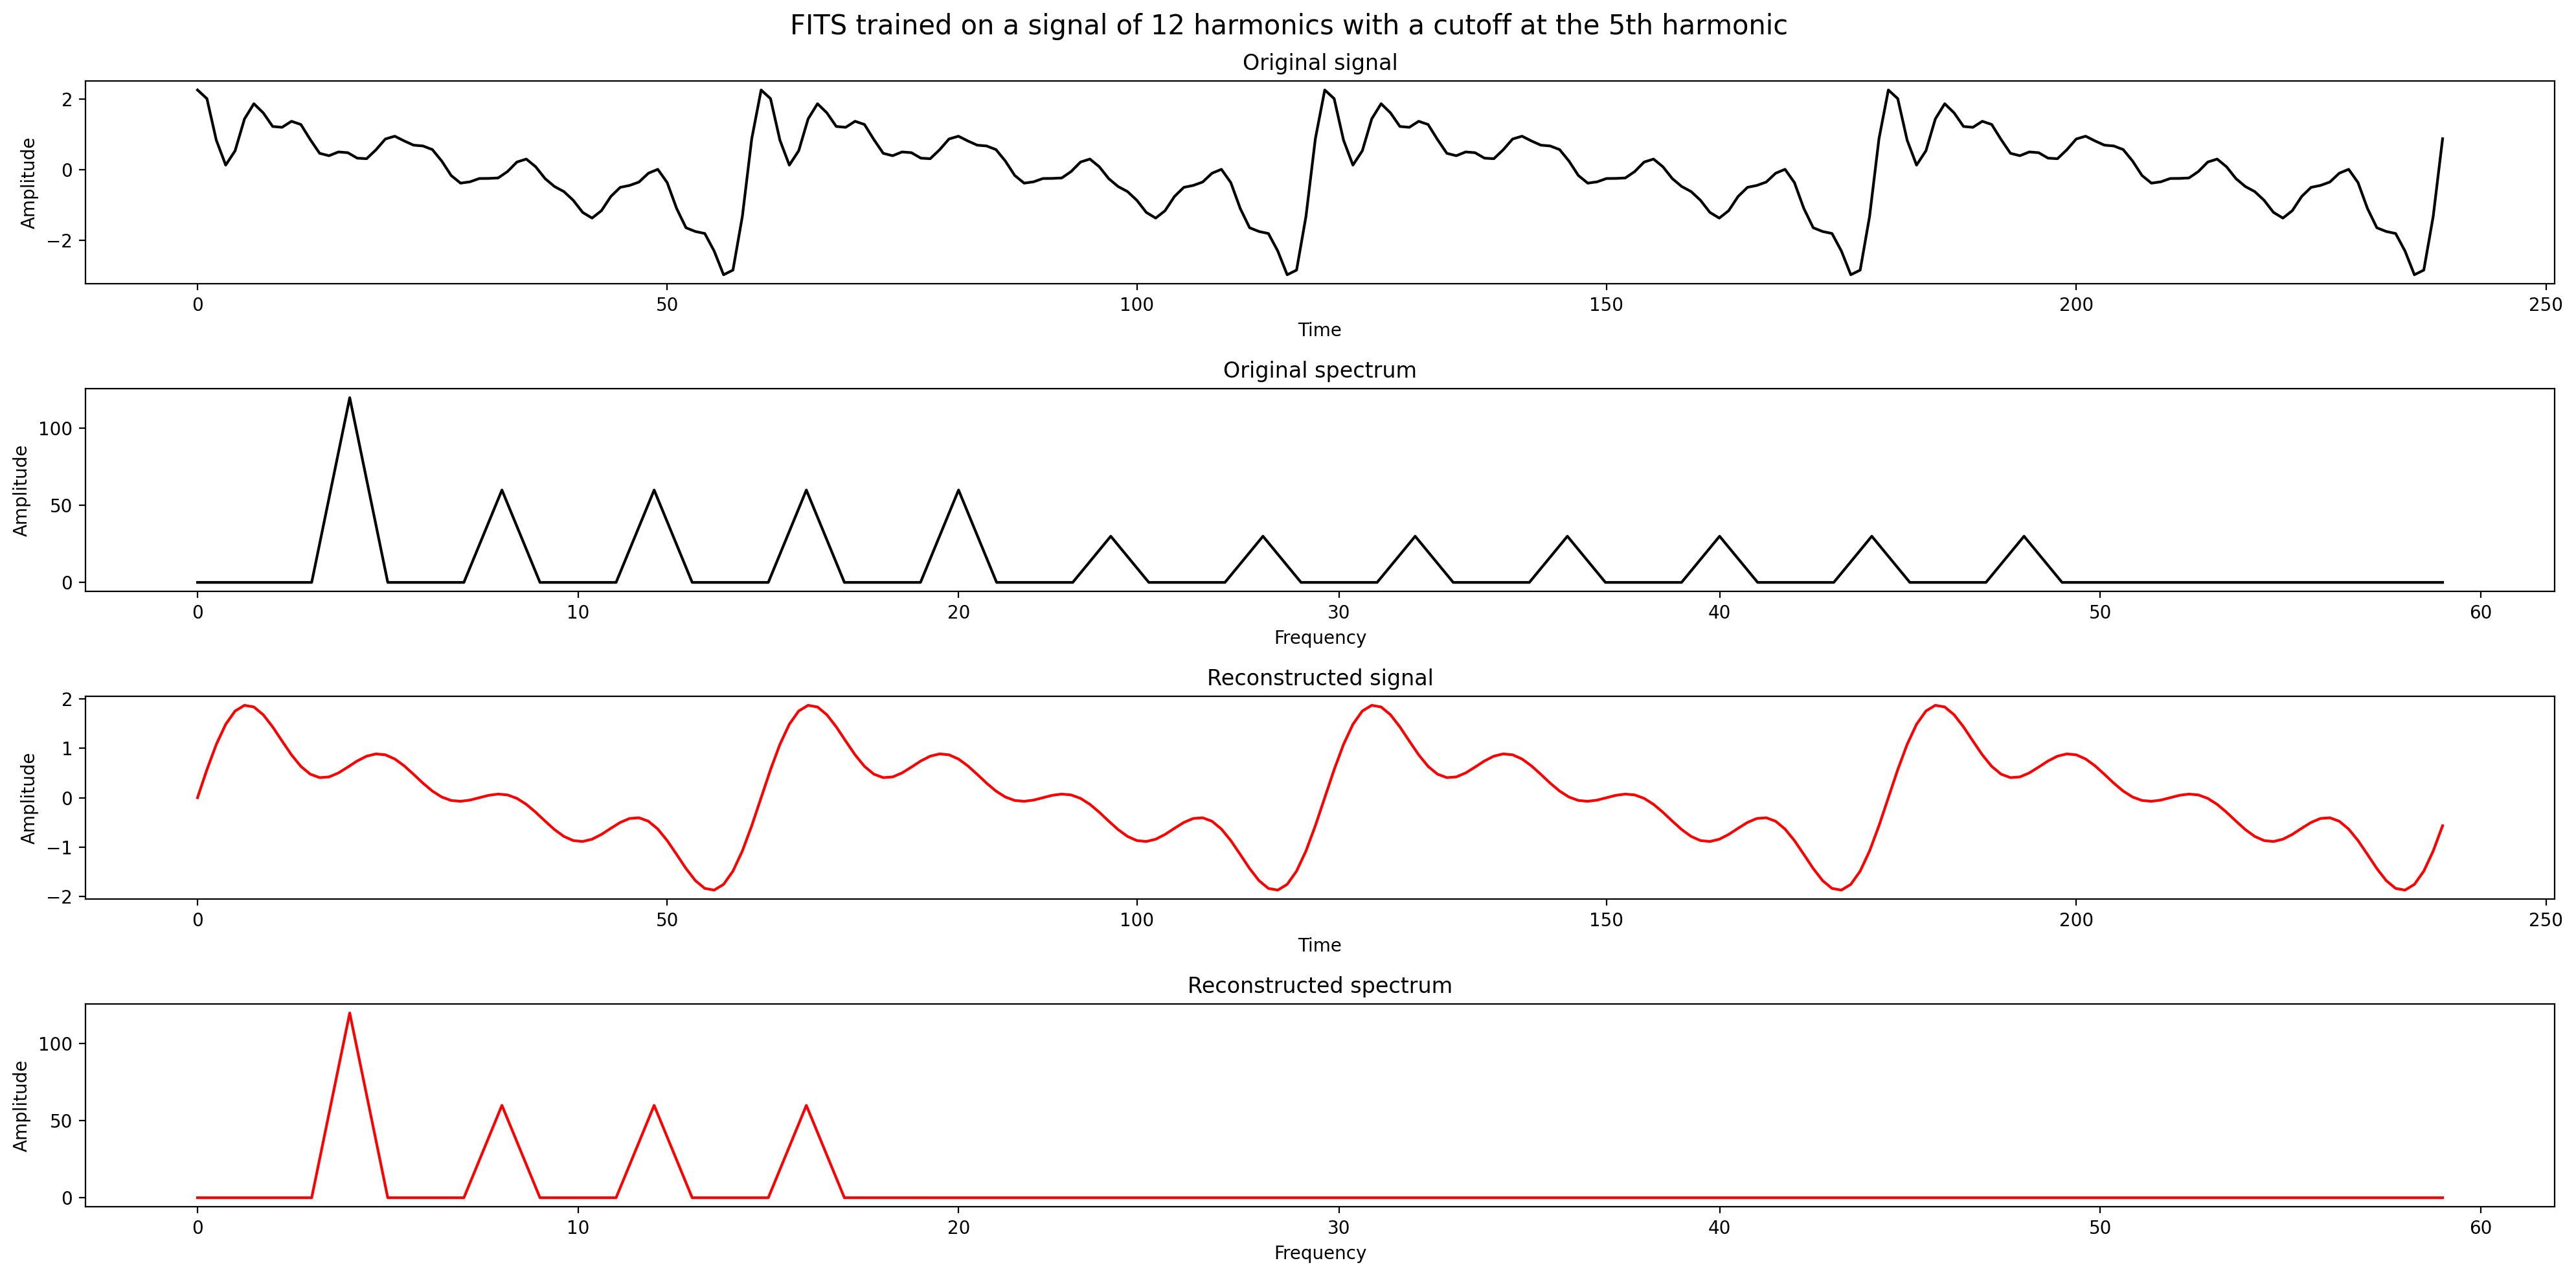

In [356]:
with torch.no_grad():
    output = model(torch.from_numpy(y[:240].reshape(1, 240, 1)).float())

fig, ax = plt.subplots(4, 1, figsize=(20, 10))
fig.suptitle(
    "FITS trained on a signal of 12 harmonics with a cutoff at the 5th harmonic",
    size=15,
)
ax[0].plot(y[:240], label="Original", color="black")
ax[0].set_title("Original signal")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time")
ax[1].plot(np.abs(np.fft.rfft(y[:240]))[:60], label="Original spectrum", color="black")
ax[1].set_title("Original spectrum")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Frequency")
ax[2].plot(output[0, :240, 0], label="Reconstructed", color="red")
ax[2].set_title("Reconstructed signal")
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("Time")
ax[3].plot(
    np.abs(np.fft.rfft(output[0, :240, 0]))[:60],
    label="Reconstructed spectrum",
    color="red",
)
ax[3].set_title("Reconstructed spectrum")
ax[3].set_ylabel("Amplitude")
ax[3].set_xlabel("Frequency")
# for a in ax:
#     a.legend()
# plt.title("FITS trained on a signal of 12 harmonics with a cutoff at the 5th harmonic")
plt.tight_layout()
plt.show()

In [357]:
with torch.no_grad():
    model.eval()
    test_loss = []
    batch = []

    for i in range(2360, num_samples - 360):
        batch.append(y[i : i + 240 + 120])
    batch_xy = np.array(batch).reshape(
        -1, 360, 1
    )  # 80 batch_size, 360 time steps, 1 feature

    batch_xy = torch.from_numpy(batch_xy).float()

    batch_x = batch_xy[:, :240, :]
    batch_y = batch_xy[:, 240:, :]

    model_optim.zero_grad()

    output = model(batch_x)

    # output=output[:,-120:,:]

    loss = criterion(
        output, batch_xy
    )  # supervise on xy (only supervise on y also achieve the same result)

    test_loss.append(loss.item())

    print("epoch: test loss: ", np.mean(test_loss))

epoch: test loss:  0.34375


In [358]:
output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

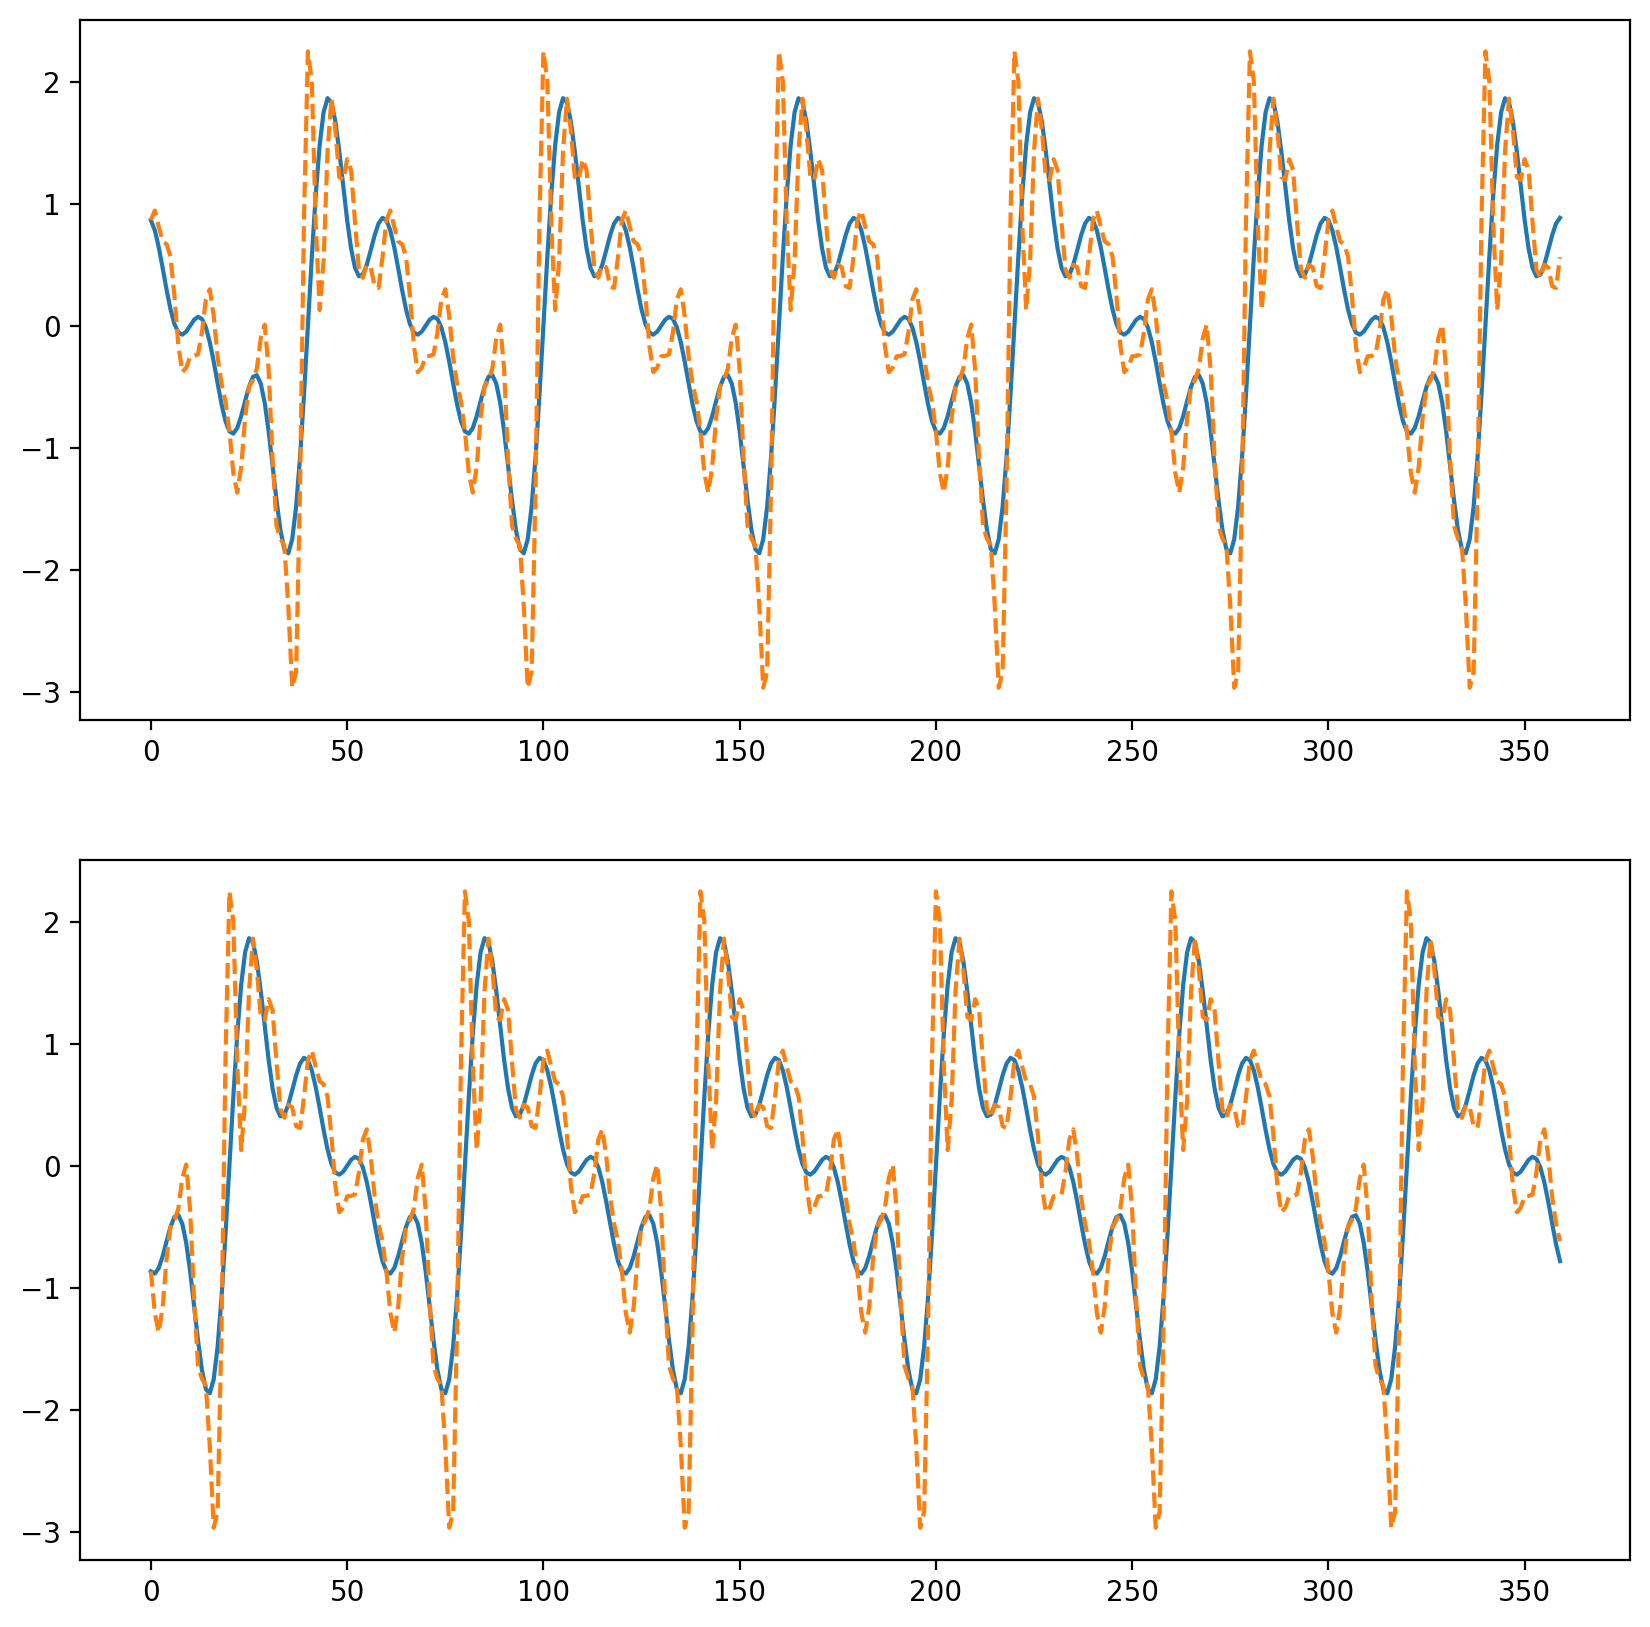

In [359]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth
plt.subplot(2, 1, 2)
plt.plot(output[200, :, 0])
plt.plot(batch_xy[200, :, 0], "--")

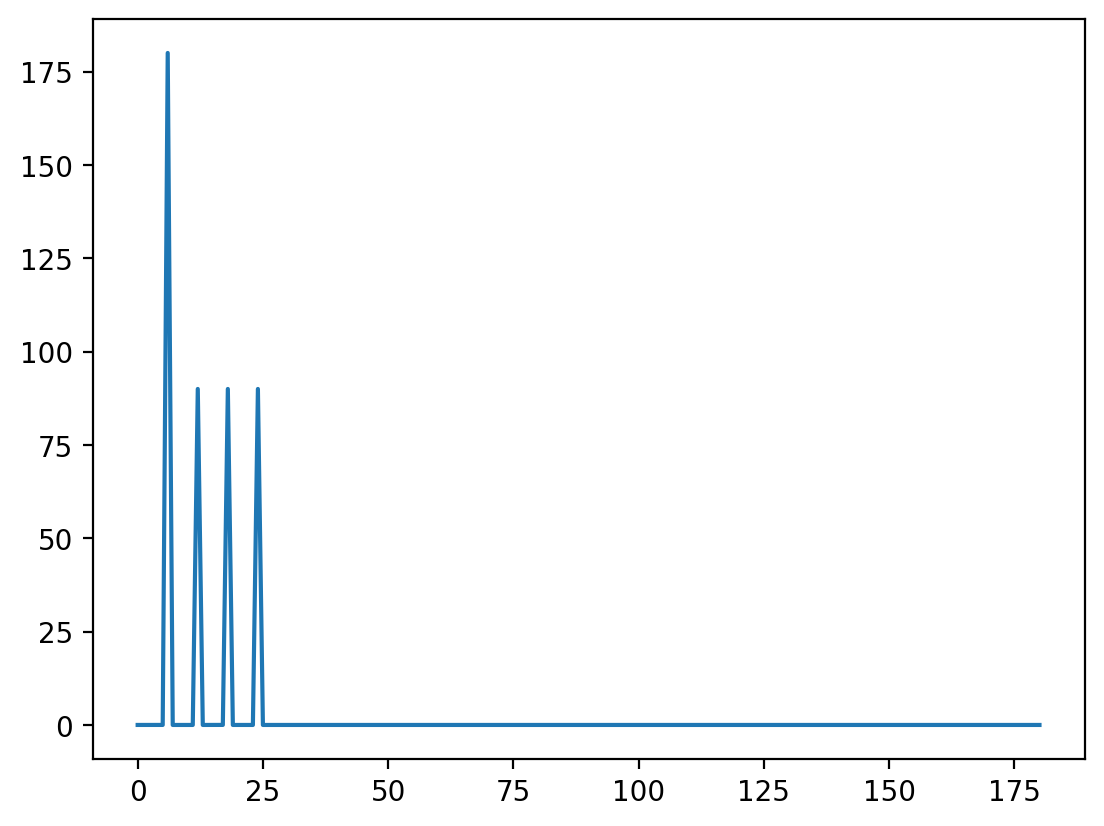

In [360]:
plt.plot(np.abs(np.fft.rfft(output[0, :, 0])))

# Frequency response

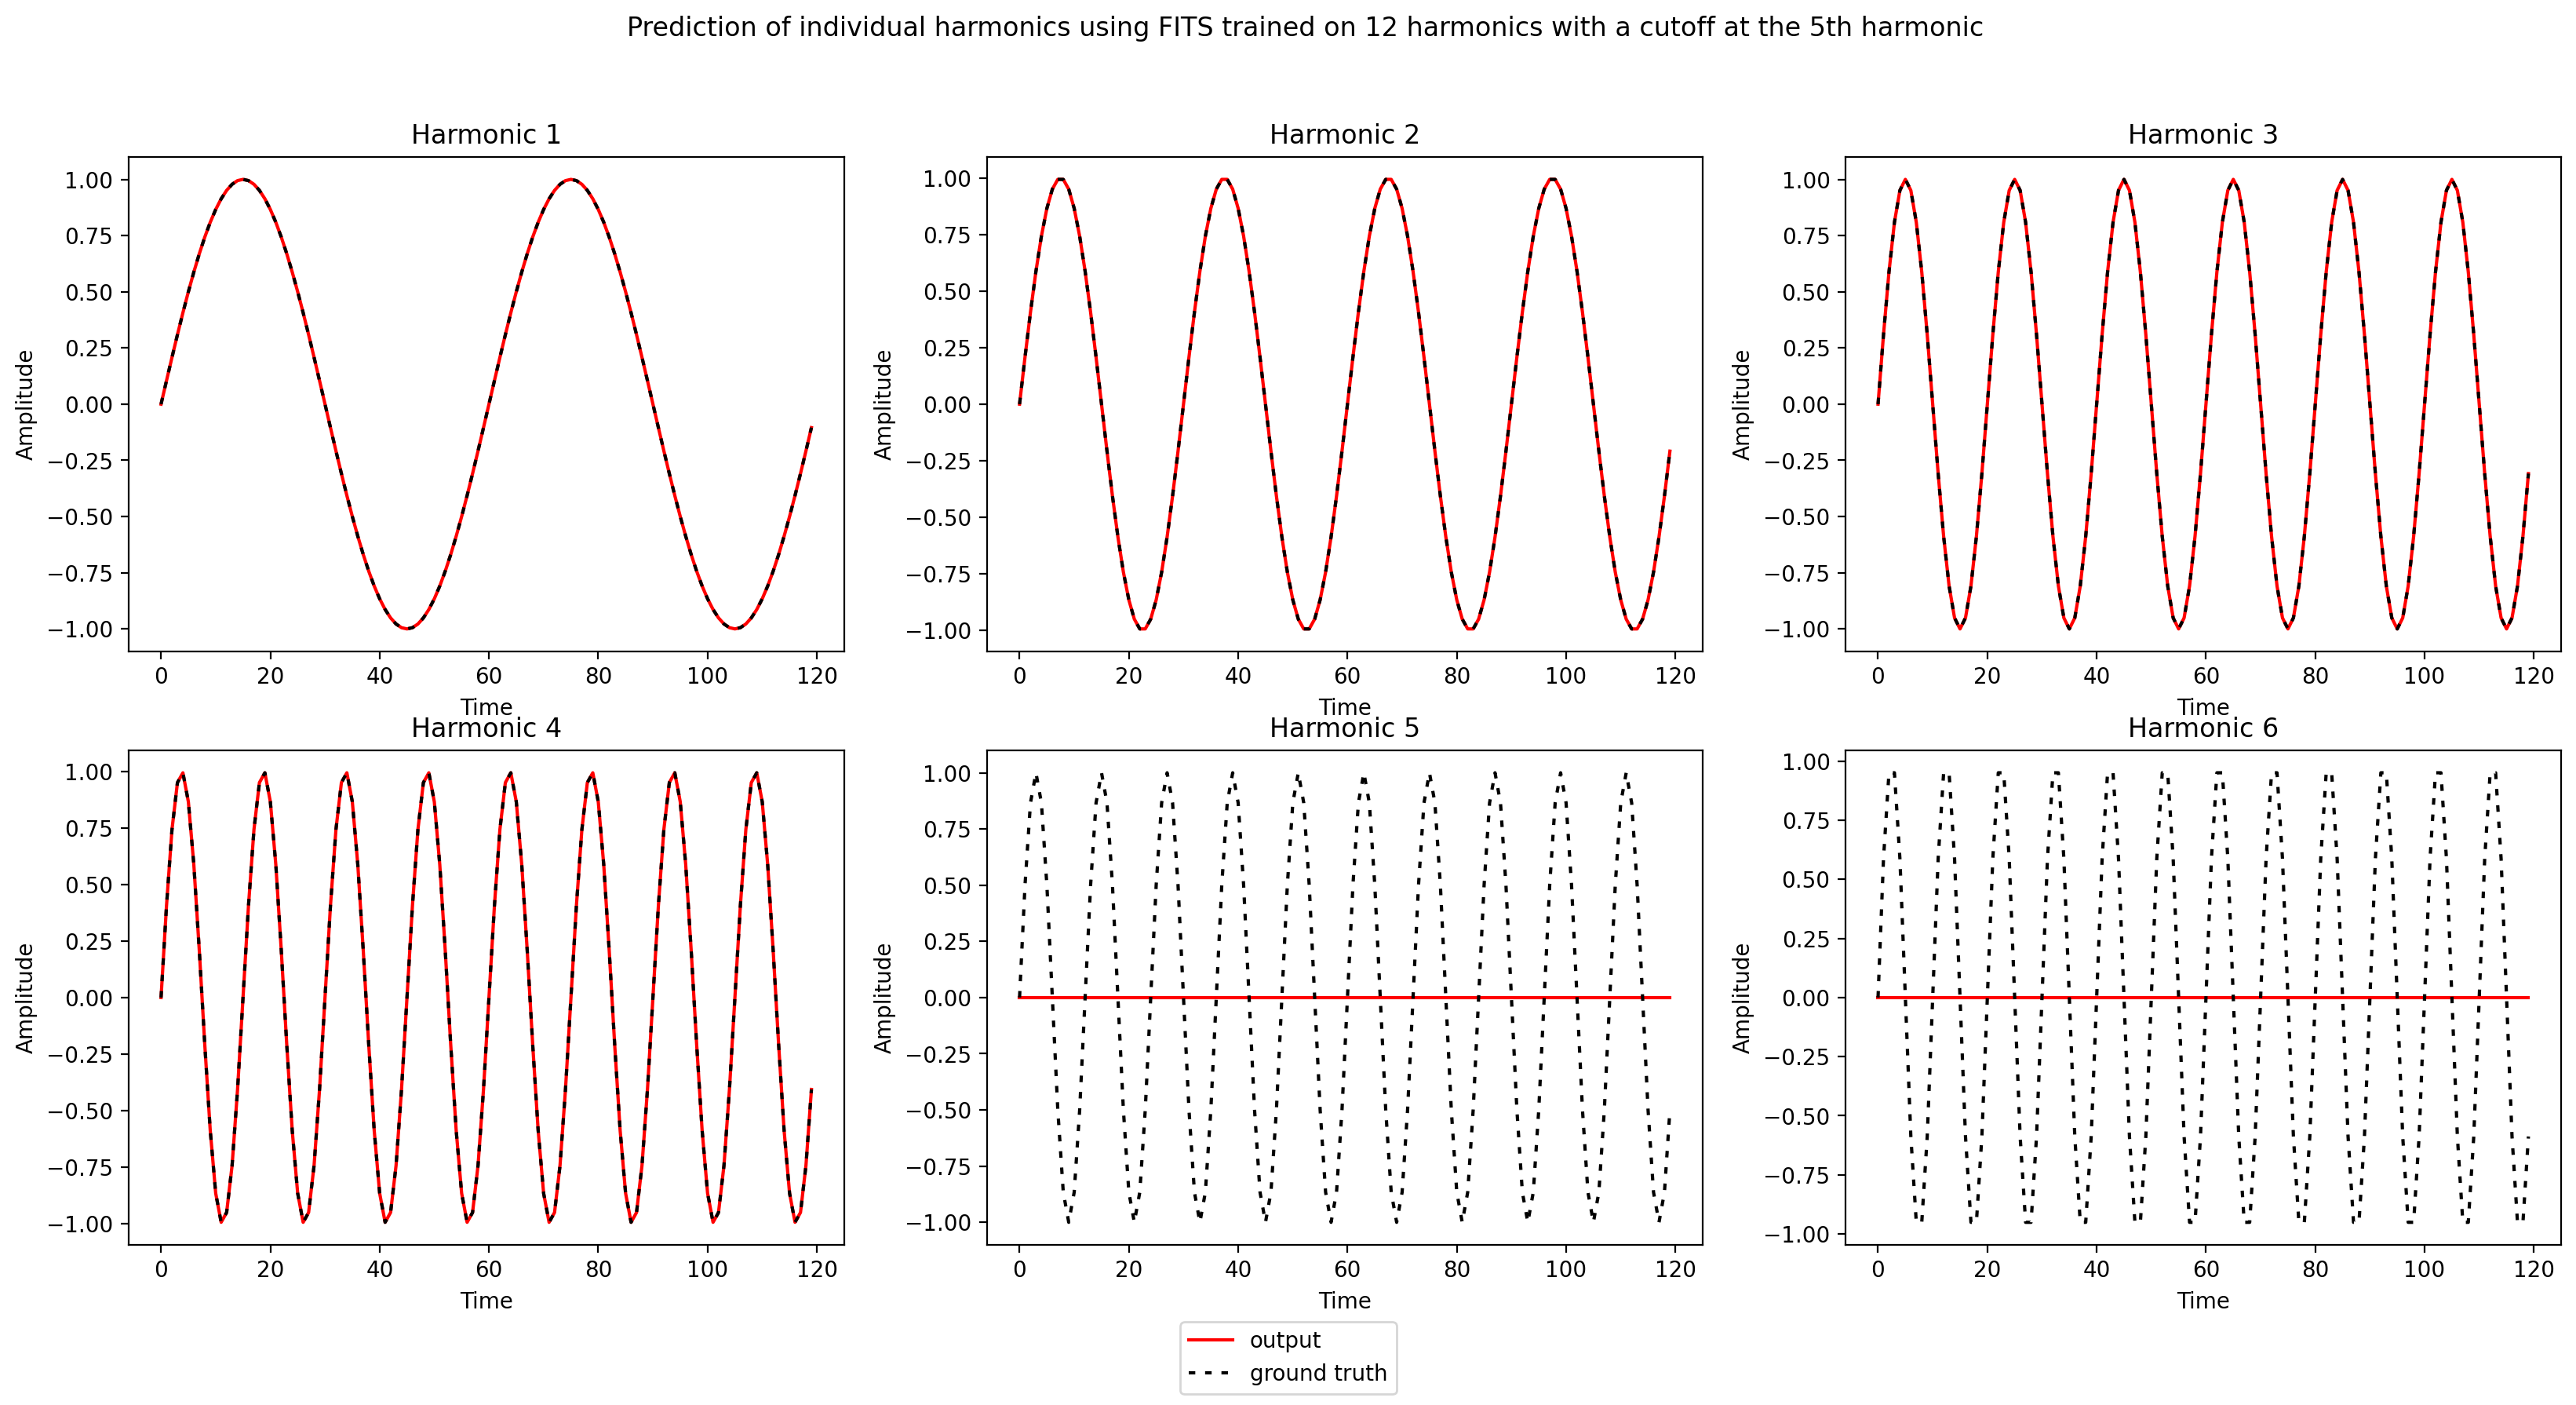

In [361]:
harmonic_bases = [1, 2, 3, 4, 5, 6]
fig, ax = plt.subplots(2, 3, figsize=(20, 9))

for harmonic_base in harmonic_bases:
    y1 = sin_function(1, base_freq / harmonic_base, 0)[:360]
    y1 = y1.reshape(1, 360, 1)
    y1 = torch.tensor(y1, dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        batch_x1 = y1[:, :240, :]
        output = model(batch_x1)
        output = output.cpu().numpy()

        y1 = y1[:, :120, :]
        output = output[:, :120, :]

        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].plot(
            output[0, :, 0], label="output", color="red"
        )
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].plot(
            y1[0, :, 0].cpu().numpy(), "--", color="black", dashes=(2, 3)
        )
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].set_title(
            f"Harmonic {harmonic_base}"
        )
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].set_ylabel("Amplitude")
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].set_xlabel("Time")

# add overall legend inside top right plot
fig.suptitle(
    "Prediction of individual harmonics using FITS trained on 12 harmonics with a cutoff at the 5th harmonic"
)
fig.legend(["output", "ground truth"], loc="lower center")
plt.show()

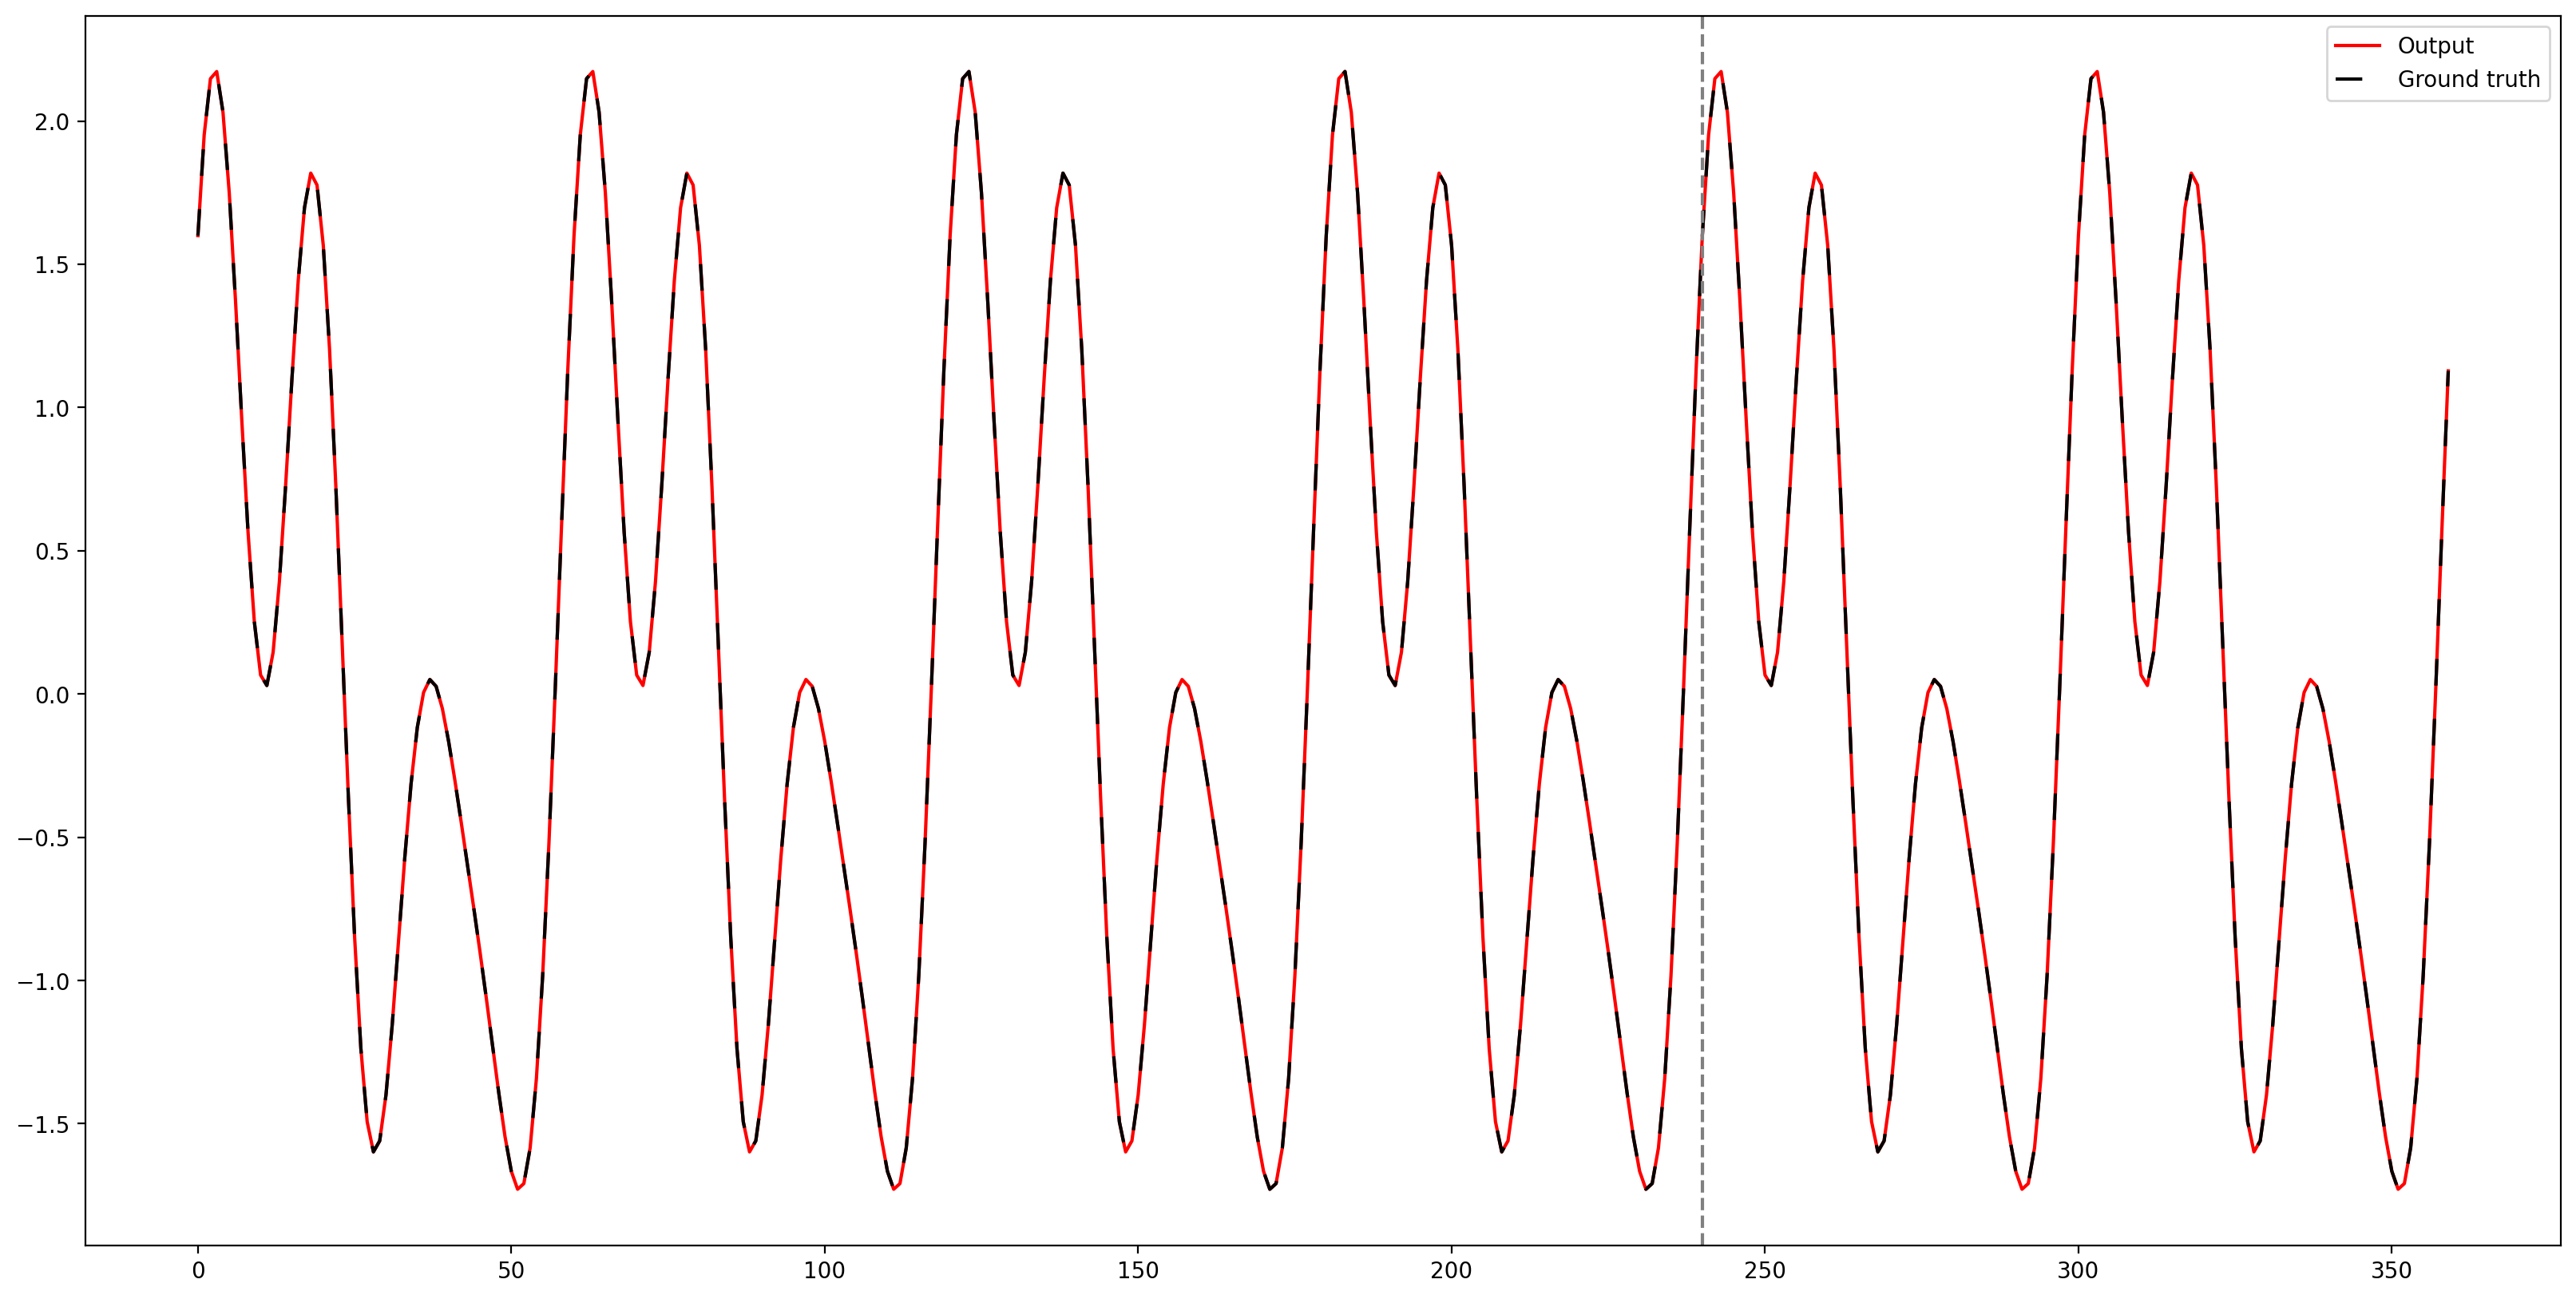

In [362]:
# create a wavelet of the combination of two frequencies

y_mix = (
    sin_function(1, 60, 0)[:360]
    + sin_function(0.5, 60, np.pi / 2)[:360]
    + sin_function(0.5, 30, 0)[:360]
    + sin_function(0.5, 20, np.pi / 2)[:360]
    + sin_function(0.5, 20, np.pi / 2)[:360]
    + sin_function(0.5, 15, 0)[:360]
    + sin_function(0.1, 15, np.pi / 2)[:360]
    # + sin_function(2, 24, np.pi / 2)[:360]
    # + sin_function(3, 60, np.pi / 2)[:360]
    # + sin_function(4, 30, np.pi / 2)[:360]
    # + sin_function(2, 24, np.pi / 2)[:360]
    # + sin_function(-1, 120, np.pi / 1)[:360]
    # + sin_function(-2, 60, np.pi / 1)[:360]
    # + sin_function(-3, 60, np.pi / 2)[:360]
    # + sin_function(1, 30, np.pi / 1)[:360]
)
y_mix = y_mix.reshape(1, 360, 1)
y_mix = torch.tensor(y_mix, dtype=torch.float32)

with torch.no_grad():
    model.eval()
    batch_x_mix = y_mix[:, :240, :]
    output = model(batch_x_mix)
    output = output.cpu().numpy()
    plt.figure(figsize=(20, 10))
    plt.plot(output[0, :, 0], label="Output", color="red")
    plt.plot(
        y_mix[0, :, 0].cpu().numpy(),
        "--",
        label="Ground truth",
        color="black",
        dashes=(8, 10),
    )
    # plt.vlines(240, -10, 10, colors="grey", linestyles="dashed")
    plt.axvline(x=240, color="grey", linestyle="--")
    plt.legend()
    # remove axis labels
    # plt.xticks([])
    # plt.yticks([])
    # remove the frame
    # for spine in plt.gca().spines.values():
    #    spine.set_visible(False)

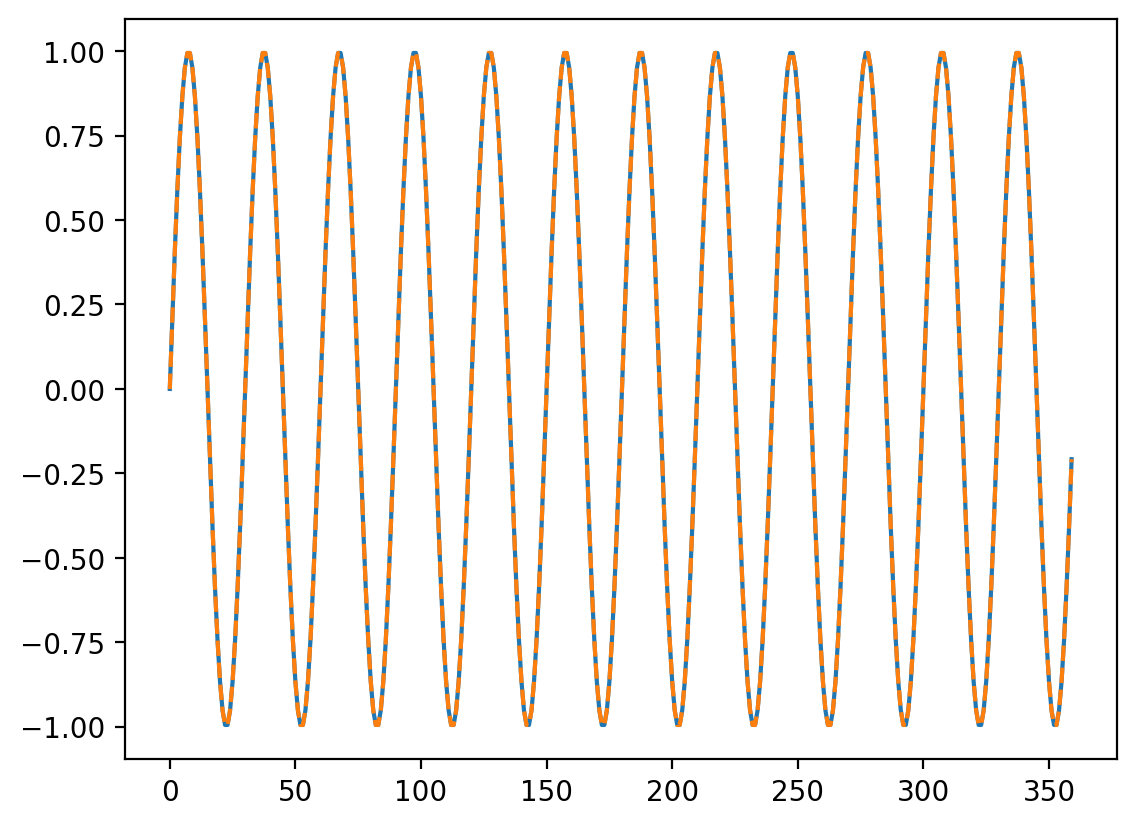

In [363]:
y3 = sin_function(1, 30, 0)[:360]
y3 = y3.reshape(1, 360, 1)
y3 = torch.tensor(y3, dtype=torch.float32)

with torch.no_grad():
    model.eval()
    batch_x3 = y3[:, :240, :]
    output = model(batch_x3)
    output = output.cpu().numpy()
    plt.plot(output[0, :, 0], label="output")
    plt.plot(y3[0, :, 0].cpu().numpy(), "--")

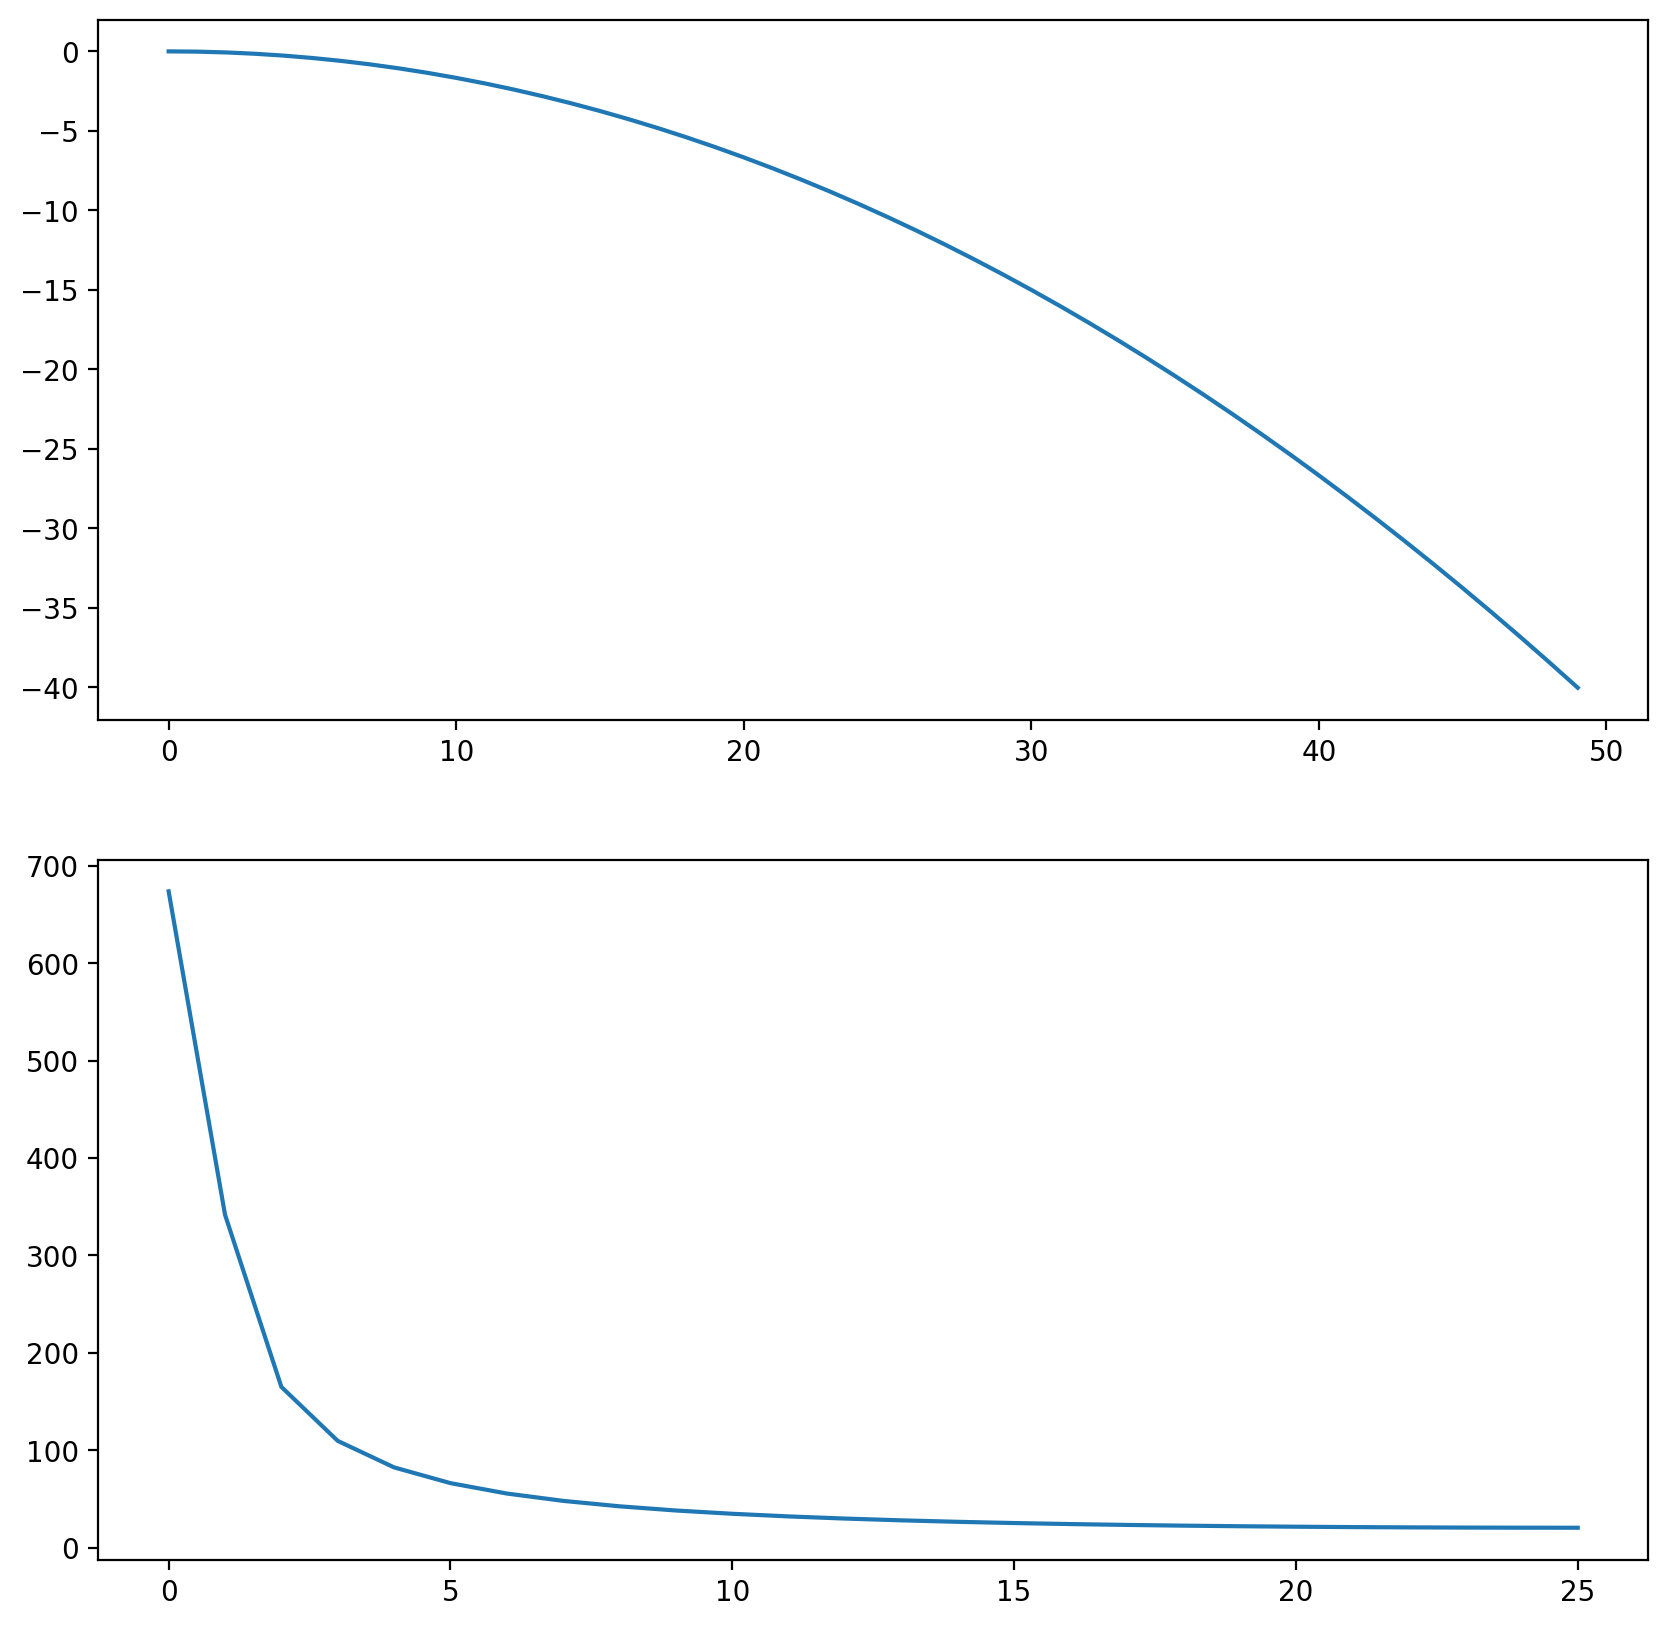

In [364]:
# create a wave of exponential function
y4 = -(np.arange(0, 50) ** 2) / 60

# plot the exponential function on upper part

# get the spectrum of the exponential function and plot it on the lower part
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(y4)
plt.subplot(2, 1, 2)
plt.plot(np.abs(np.fft.rfft(y4)))